<a id='top'></a><a name='top'></a>
# Chapter 5: Feature Engineering and Syntactic Similarity

**Blueprints for Text Analysis Using Python**

* [Introduction](#introduction)
* [5.0 Imports and Setup](#5.0)
* [5.1 A Toy Dataset for Experimentation](#5.1)
* [5.2 Blueprint: Building Your Own Vectorizer](#5.2)
    - [5.2.1 Enumerating the Vocabulary](#5.2.1)
    - [5.2.2 Vectorizing Documents](#5.2.2)
    - [5.2.3 The Document-Term Matrix](#5.2.3)
    - [5.2.4 The Similarity Matrix](#5.2.4)
* [5.3 Bag-of-Words Models](#5.3)
    - [5.3.1 Blueprint: Using scikit-learn's CountVectorizer](#5.3.1)
    - [5.3.2 Blueprint: Calculating Similarities](#5.3.2)
* [5.4 TF-IDF Models](#5.4)
    - [5.4.1 Optimized Document Vectors with TfidfTransformer](#5.4.1)
    - [5.4.2 Introducing the ABC Datset](#5.4.2)
    - [5.4.3 Blueprint: Reducing Feature Dimensions](#5.4.3)
    - [5.4.4 Blueprint: Improving Features by Making Them More Specific](#5.4.4)
    - [5.4.5 Blueprint: Using Lemmas Instead of Words for Vectorizing Documents](#5.4.5)
    - [5.4.6 Blueprint: Limit Word Types](#5.4.6)
    - [5.4.7 Blueprint: Remove Most Common Words](#5.4.7)
    - [5.4.8 Blueprint: Adding Context via N-Grams](#5.4.8)
* [5.5 Syntactic Similarity in the ABC Dataset](#5.5)
    - [5.5.1 Blueprint: Finding Most Similar Headlines to a Made-up Headline](#5.5.1)
    - [5.5.2 Blueprint: Finding the Two Most Similar Documents in a Large Corpus (Much More Difficult)](#5.5.2)
    - [5.5.3 Blueprint: Finding Related Words)](#5.5.3)
    - [5.5.4 Tips for Long-Running Programs like Syntactic Similarity](#5.5.4)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset

* google-10000-english.txt: [script](#google-10000-english.txt), [source](https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english.txt)
* ABC Australian news 2003-2017: [script](#abcnews-date-text.csv.gz), [source](https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/abcnews/abcnews-date-text.csv.gz)


### Explore

* How to convert documents to vectors using words or combinations as features. 
* The importance of similarity of documents and ways to calculate it.
* How to design and implement a custom vectorizer.
* The Bag-of-Words model and TF-IDF improvements to it.

---
<a name='5.0'></a><a id='5.0'></a>
# 5.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
# # Start with clean project
# !rm -f *.gz 
# !rm -f *.txt 
# !rm -f *.csv 
# !rm -f *.pkl 
# !rm -f *.py
# !ls -l

In [2]:
req_file = "requirements_05.txt"

In [3]:
%%writefile {req_file}
isort
scikit-learn-intelex
tqdm
watermark

Writing requirements_05.txt


In [4]:
import sys

IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
%%writefile imports.py
# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import locale
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm.auto import tqdm
from watermark import watermark

Writing imports.py


In [6]:
!isort imports.py
!cat imports.py

# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import locale
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm.auto import tqdm
from watermark import watermark


In [7]:
# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import locale
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm.auto import tqdm
from watermark import watermark

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

print(watermark(iversions=True, globals_=globals(),python=True, machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

spacy     : 3.5.1
sys       : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
seaborn   : 0.12.1
pandas    : 1.5.3
numpy     : 1.23.5
matplotlib: 3.6.2



In [9]:
# Need to cast stopwords to a list so we can pass to TfidfVectorizer
stopwords = list(STOP_WORDS)

matrix_data = []

In [10]:
title_w = 10
val_w = 10
title_columns="Columns"
title_rows="Rows"
title_elements="Elements"
title_bytes="Bytes"
title_gb="Gigabytes"
    
df_names = [title_columns, title_elements, title_rows, "title"]
    
def examine_matrix(dt, title, add_to_df=True):

    print(f"{title_columns:<{title_w}} {dt.shape[0]:{val_w},}")
    print(f"{title_rows:<{title_w}} {dt.shape[1]:{val_w},}")
    print(f"{title_elements:<{title_w}} {dt.nnz:{val_w},}")
    print(f"{title_bytes:<{title_w}} {dt.data.nbytes:{val_w},}")
    print(f"{title_gb:<{title_w}} {round(dt.data.nbytes / (1024*1024*1024), 5):{val_w},}")

    matrix_row = {
        'title': title,
        title_columns: dt.shape[0],
        title_rows: dt.shape[1],
        title_elements: dt.nnz
    }
    if add_to_df:
        matrix_data.append(matrix_row)

In [11]:
def show(matrix_data):
    results = pd.DataFrame.from_records(matrix_data, index='title')
    row = results.iloc[:][['Columns','Rows','Elements']]
    row.plot(kind='barh', ylabel="", fontsize=8)
    
    plt.show()

---
<a name='5.1'></a><a id='5.1'></a>
# 5.1 A Toy Dataset for Experimentation
<a href="#top">[back to top]</a>

We use a few sentences from *A Tale of Two Cities* by Charles Dickens.

    It was the best of times.
    It was the worst of times.
    It was the age of wisdom.
    It was the age of foolishness.

---
<a name='5.2'></a><a id='5.2'></a>
# 5.2 Blueprint: Building Your Own Vectorizer
<a href="#top">[back to top]</a>

We implement a simple *one-hot vectorizer*. This creates binary vectors by representing the occurrence of a word in a document via 1 or 0.

<a name='5.2.1'></a><a id='5.2.1'></a>
## 5.2.1 Enumerating the Vocabulary
<a href="#top">[back to top]</a>

Convert words to the dimensions of the vectors. Extracting words from the text is done via tokenization.

In terms of representation, we are only interested in whether a word appears in a document or not.

In [12]:
sentences = ["It was the best of times", 
             "it was the worst of times", 
             "it was the age of wisdom", 
             "it was the age of foolishness"]

tokenized_sentences = [[t for t in sentence.split()] for sentence in sentences]
pp.pprint(tokenized_sentences)

[   ['It', 'was', 'the', 'best', 'of', 'times'],
    ['it', 'was', 'the', 'worst', 'of', 'times'],
    ['it', 'was', 'the', 'age', 'of', 'wisdom'],
    ['it', 'was', 'the', 'age', 'of', 'foolishness']]


In [13]:
vocabulary = set([w for s in tokenized_sentences for w in s])
pp.pprint(vocabulary)

{   'It',
    'age',
    'best',
    'foolishness',
    'it',
    'of',
    'the',
    'times',
    'was',
    'wisdom',
    'worst'}


In [14]:
pd.DataFrame([[w, i] for i,w in enumerate(vocabulary)])

,0,1
0,wisdom,0
1,It,1
2,foolishness,2
3,age,3
4,best,4
5,worst,5
6,the,6
7,was,7
8,times,8
9,of,9


<a name='5.2.2'></a><a id='5.2.2'></a>
## 5.2.2 Vectorizing Documents
<a href="#top">[back to top]</a>

To enable comparisons among vectors, we have to ensure the vectors for each document have the same number of dimensions.

To achieve this, we use the same dictionary for all documents. If the document doesn't contain a word, we represent that with a 0 at the corresponding position, otherwise we use a 1. By convention, row vectors are used for documents. The dimension of vectors is as big as the length of the dictionary. In large projects, the vocabulary can easily exceed 100,000 words. 

In [15]:
def onehot_encode(tokenized_sentence):
    return [1 if w in tokenized_sentence else 0 for w in vocabulary]

onehot = [onehot_encode(tokenized_sentence) for tokenized_sentence in tokenized_sentences]

for (sentence, oh) in zip(sentences, onehot):
    print("%s: %s" % (oh, sentence))

[0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]: It was the best of times
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]: it was the worst of times
[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]: it was the age of wisdom
[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]: it was the age of foolishness


In [16]:
sim = [onehot[0][i] & onehot[1][i] for i in range(0, len(vocabulary))]
sum(sim)

4

In [17]:
# Cannot use sets as columns anymore in Pandas, so we use a list.
vocabulary = list(vocabulary)
pd.DataFrame(onehot, columns=vocabulary)

,wisdom,It,foolishness,age,best,worst,the,was,times,of,it
0,0,1,0,0,1,0,1,1,1,1,0
1,0,0,0,0,0,1,1,1,1,1,1
2,1,0,0,1,0,0,1,1,0,1,1
3,0,0,1,1,0,0,1,1,0,1,1


### Out of vocabulary

In [18]:
onehot_encode("the age of wisdom is the best of times".split())

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0]

If we try to vectorize a sentence with only unknown words, we get a null vector

In [19]:
onehot_encode("John likes to watch movies. Mary likes movies too.".split())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

<a name='5.2.3'></a><a id='5.2.3'></a>
## 5.2.3 The Document-Term Matrix
<a href="#top">[back to top]</a>

If we arrange the row vectors for each document in a matrix with the row enumerating the documents, we create a *document matrix*. This is a vector representation of all documents, and is a basic building block for many machine learning tasks. Here we will use it to calculate document similarities. 

With larger vocabularies, we can use spare vectors and matrices from SciPy.

In [20]:
pd.DataFrame(onehot, columns=vocabulary)

,wisdom,It,foolishness,age,best,worst,the,was,times,of,it
0,0,1,0,0,1,0,1,1,1,1,0
1,0,0,0,0,0,1,1,1,1,1,1
2,1,0,0,1,0,0,1,1,0,1,1
3,0,0,1,1,0,0,1,1,0,1,1


### Calculating similarities

Calculate the similarity of the first two sentences.

In [21]:
sim = [onehot[0][i] & onehot[1][i] for i in range(0, len(vocabulary))]
sum(sim)

4

We can also calculate the similarity by using the scalar product of the two document vectors. 

In [22]:
np.dot(onehot[0], onehot[1])

4

<a name='5.2.4'></a><a id='5.2.4'></a>
## 5.2.4 The Similarity Matrix
<a href="#top">[back to top]</a>

We can use a shortcut to calculate all numbers in a matrix, in order to find the similarity of all documents to each other. 

In [23]:
np.dot(onehot, np.transpose(onehot))

array([[6, 4, 3, 3],
       [4, 6, 4, 4],
       [3, 4, 6, 5],
       [3, 4, 5, 6]])

### One-Hot Encoding with scikit-learn

We can also do vectorization with scikit-learn. For this, we do not use `OneHotEncoder`, since it suitable only for categorical features. Instead, we use `MultiLabelBinarizer`.


In [24]:
lb = MultiLabelBinarizer()
lb.fit([vocabulary])
lb.transform(tokenized_sentences)

array([[1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
       [0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0]])

---
<a name='5.3'></a><a id='5.3'></a>
# 5.3 Bag-of-Words Models
<a href="#top">[back to top]</a>

One-hot encoding is a basic representation of documents as vectors, however it does not represent the number of times words appear. In order to represent word frequency, we can use a *bag-of-words* representation. 

Although somewhat simplistic, these models are in wide use. For cases such as classification and sentiment detection, they work reasonably. Moreover, there are topic modeling methods like Latent Dirichlet Allocation (LDA), which explicitly requires a bag-of-words model.

<a name='5.3.1'></a><a id='5.3.1'></a>
## 5.3.1 Blueprint: Using scikit-learn's CountVectorizer
<a href="#top">[back to top]</a>

We use scikit-learn's `CountVectorizer` algorithm to create a bag-of-words model.

`CountVectorizer` works in two steps:

1. Learn the vocabulary
2. Transform the documents to vectors.

In [25]:
cv = CountVectorizer()

# Default parameters
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

Add additional sentences to our dataset. 

In [26]:
more_sentences = sentences + ["John likes to watch movies. Mary likes movies too.",
                              "Mary also likes to watch football games."]
pd.DataFrame(more_sentences)

,0
0,It was the best of times
1,it was the worst of times
2,it was the age of wisdom
3,it was the age of foolishness
4,John likes to watch movies. Mary likes movies ...
5,Mary also likes to watch football games.


### Learning and fitting the vocabulary

In [27]:
cv.fit(more_sentences)

CountVectorizer()

Examine what CountVectorizer uses as vocabulary, which is called *feature names*.

In [28]:
pp.pprint(cv.get_feature_names_out())

array(['age', 'also', 'best', 'foolishness', 'football', 'games', 'it',
       'john', 'likes', 'mary', 'movies', 'of', 'the', 'times', 'to',
       'too', 'was', 'watch', 'wisdom', 'worst'], dtype=object)


### Transforming the vocabulary to vectors

In this second step, we use `CountVectorizer` to transform the documents to the vector representation. 

In [29]:
dt = cv.transform(more_sentences)

examine_matrix(dt, 'simple', add_to_df=False)

Columns             6
Rows               20
Elements           38
Bytes             304
Gigabytes         0.0


We created a document-term matrix, however it is a different object, a sparse matrix.

Recover our original document-matrix. by transforming the sparse matrix to a dense array. 

In [30]:
# Easier to read as a Pandas Dataframe
pd.DataFrame(dt.toarray(), columns=cv.get_feature_names_out())

,age,also,best,foolishness,football,games,it,john,likes,mary,movies,of,the,times,to,too,was,watch,wisdom,worst
0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,1
2,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0
3,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,2,1,2,0,0,0,1,1,0,1,0,0
5,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0


<a name='5.3.2'></a><a id='5.3.2'></a>
## 5.3.2 Blueprint: Calculating Similarities
<a href="#top">[back to top]</a>

Finding similarities between documents is now more difficult since we cannot just count the common 1s in the document. We also cannot use the dot product, since it is sensitive to the length of the vector. 

Instead, we use the cosine of the angle between two vectors.  scikit-learn provides the `cosine_similarity` utility function for this. This function is properly normalized and only takes values between 0 and 1.

In [31]:
cosine_similarity(dt[0], dt[1])

array([[0.83333333]])

We can also calculate the similarity of all documents with `cosine_similarity`, by directly passing the matrices.

In [32]:
pd.DataFrame(cosine_similarity(dt, dt))

,0,1,2,3,4,5
0,1.000000,0.833333,0.666667,0.666667,0.000000,0.000000
1,0.833333,1.000000,0.666667,0.666667,0.000000,0.000000
2,0.666667,0.666667,1.000000,0.833333,0.000000,0.000000
3,0.666667,0.666667,0.833333,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.524142
5,0.000000,0.000000,0.000000,0.000000,0.524142,1.000000


In [33]:
len(more_sentences)

6

---
<a name='5.4'></a><a id='5.4'></a>
# 5.4 TF-IDF Models
<a href="#top">[back to top]</a>

TF-IDF stands for "Term Frequency - Inverse Document Frequency".

TF-IDF counts the number of total word occurrences. It will reduce weights of frequent words and at the same time increase the weights of uncommon words.

Conceptually this is related to the concept of entropy, which says that a low-probability value carries more information than a more likely value.

<a name='5.4.1'></a><a id='5.4.1'></a>
## 5.4.1 Optimized Document Vectors with TfidfTransformer
<a href="#top">[back to top]</a>

A better measure for information (compared to simply counting terms) is calculating the inverted document frequency and using a penalty for very common words. The TF-IDF weight can be calculated from the bag-of-words model. We can use this on the previous model and see how the weights of the document-term matrix change. 

`TfidfTransformer` transforms a count matrix to a normalized tf or tf-idf representation.

In [34]:
tfidf = TfidfTransformer()
tfidf_dt = tfidf.fit_transform(dt)

examine_matrix(dt, 'TfidfTransformer', add_to_df=False)

Columns             6
Rows               20
Elements           38
Bytes             304
Gigabytes         0.0


In [35]:
pd.DataFrame(tfidf_dt.toarray(), columns=cv.get_feature_names_out())

,age,also,best,foolishness,football,games,it,john,likes,mary,movies,of,the,times,to,too,was,watch,wisdom,worst
0,0.000000,0.000000,0.56978,0.00000,0.000000,0.000000,0.338027,0.000000,0.000000,0.000000,0.000000,0.338027,0.338027,0.467228,0.000000,0.000000,0.338027,0.000000,0.00000,0.00000
1,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.338027,0.000000,0.000000,0.000000,0.000000,0.338027,0.338027,0.467228,0.000000,0.000000,0.338027,0.000000,0.00000,0.56978
2,0.467228,0.000000,0.00000,0.00000,0.000000,0.000000,0.338027,0.000000,0.000000,0.000000,0.000000,0.338027,0.338027,0.000000,0.000000,0.000000,0.338027,0.000000,0.56978,0.00000
3,0.467228,0.000000,0.00000,0.56978,0.000000,0.000000,0.338027,0.000000,0.000000,0.000000,0.000000,0.338027,0.338027,0.000000,0.000000,0.000000,0.338027,0.000000,0.00000,0.00000
4,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.305609,0.501208,0.250604,0.611219,0.000000,0.000000,0.000000,0.250604,0.305609,0.000000,0.250604,0.00000,0.00000
5,0.000000,0.419233,0.00000,0.00000,0.419233,0.419233,0.000000,0.000000,0.343777,0.343777,0.000000,0.000000,0.000000,0.000000,0.343777,0.000000,0.000000,0.343777,0.00000,0.00000


In [36]:
pd.DataFrame(cosine_similarity(tfidf_dt, tfidf_dt))

,0,1,2,3,4,5
0,1.000000,0.675351,0.457049,0.457049,0.00000,0.00000
1,0.675351,1.000000,0.457049,0.457049,0.00000,0.00000
2,0.457049,0.457049,1.000000,0.675351,0.00000,0.00000
3,0.457049,0.457049,0.675351,1.000000,0.00000,0.00000
4,0.000000,0.000000,0.000000,0.000000,1.00000,0.43076
5,0.000000,0.000000,0.000000,0.000000,0.43076,1.00000


<a name='5.4.2'></a><a id='5.4.2'></a>
## 5.4.2 Introducing the ABC Dataset
<a href="#top">[back to top]</a>

We use a dataset from Kaggle containing news headlines, originating from [ABC Australian news 2003-2017](`CountVectorizer`).

<a id='abcnews-date-text.csv.gz'></a><a name='abcnews-date-text.csv.gz'></a>
### Dataset: abcnews-date-text.csv.gz
<a href="#top">[back to top]</a>

In [37]:
ABCNEWS_FILE = 'abcnews-date-text.csv.gz'
!wget -nc -q https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/abcnews/abcnews-date-text.csv.gz
!ls -l {ABCNEWS_FILE}

-rw-r--r--  1 gb  staff  19282568 Mar 30 23:28 abcnews-date-text.csv.gz


In [38]:
headlines_orig = pd.read_csv(ABCNEWS_FILE, parse_dates=["publish_date"])
headlines_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103663 entries, 0 to 1103662
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   publish_date   1103663 non-null  datetime64[ns]
 1   headline_text  1103663 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 16.8+ MB


### Shorten size of headline, as it takes too long to process the original length

In [39]:
# Shorten dataset
# headlines = headlines_orig.sample(frac=.1)
headlines = headlines_orig.sample(n=20_000)
print(f"{len(headlines):,}")

20,000


In [40]:
headlines.sample(5)

,publish_date,headline_text
808910,2013-08-06,false tweet tim picton revealed marginal adela...
241542,2006-06-06,producers urged to watch for bird pest
88438,2004-05-03,labor urges voters not to fall for tax bribe
1082344,2017-07-03,wa public sector reform payouts to senior staff
647690,2011-10-25,mcclelland sri lanka decision


In [41]:
tfidf = TfidfVectorizer()
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.2 TfidfVectorizer')

Columns        20,000
Rows           17,887
Elements      127,361
Bytes       1,018,888
Gigabytes     0.00095


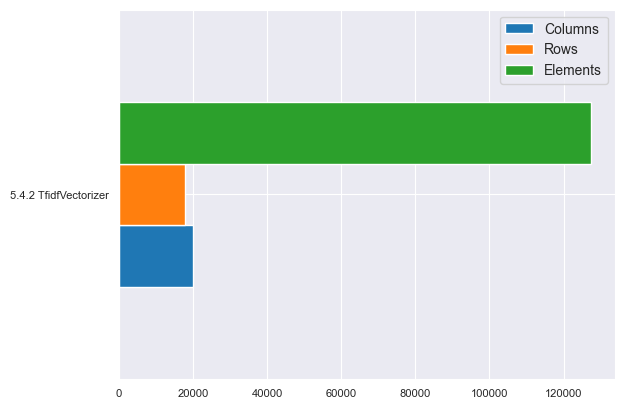

In [42]:
show(matrix_data)

Calculate the similarity between two vectors is very efficient via `cosine_similarity`.

In [43]:
%%time
# Use Pandas for better UI.
pd.DataFrame(cosine_similarity(dt[0:10000], dt[0:10000]))

CPU times: user 360 ms, sys: 518 ms, total: 877 ms
Wall time: 1.57 s


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.036903,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.065149,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,1.0,0.000000,0.0,0.048675,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.036854,0.0,0.0,0.029762,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.029762,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.036832,0.0,0.0,1.000000,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


<a name='5.4.3'></a><a id='5.4.3'></a>
## 5.4.3 Blueprint: Reducing Feature Dimensions
<a href="#top">[back to top]</a>

We can optimize vectorization by removing unnecesary features when calculating similarities. 

### Removing Stopwords

This does not reduce the number of dimensions much, but it should drastically decrease the number of stored elements. 

In [44]:
print(len(stopwords))

326


In [45]:
tfidf = TfidfVectorizer(stop_words=stopwords)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords')

Columns        20,000
Rows           17,662
Elements      102,517
Bytes         820,136
Gigabytes     0.00076


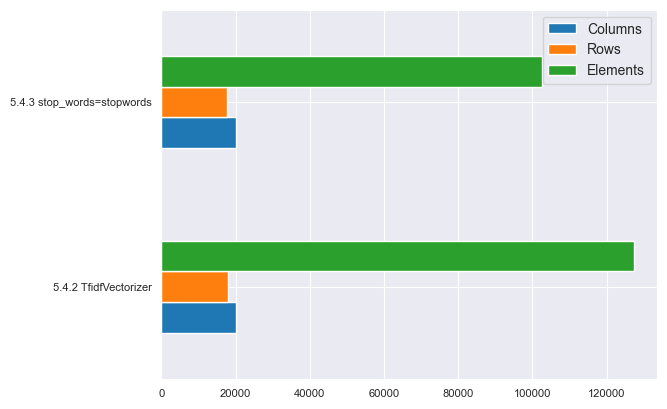

In [46]:
show(matrix_data)

### Minimum frequency

Components can contribute only if both vectors have a nonzero value at the corresponding index. Hence, we can neglect all words occurring less than twice. 

`TfidfVectorizer` has a parameter called `min_df` for this.

In [47]:
tfidf = TfidfVectorizer(stop_words=stopwords, min_df=2)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, min_df=2')

Columns        20,000
Rows            8,928
Elements       93,783
Bytes         750,264
Gigabytes      0.0007


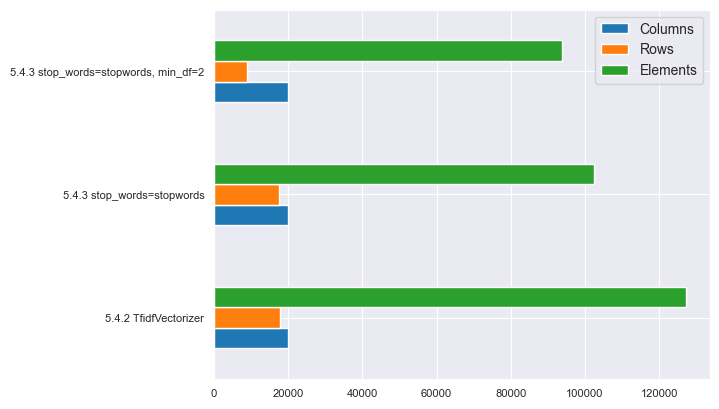

In [48]:
show(matrix_data)

### Using min_df as a fraction

In [49]:
tfidf = TfidfVectorizer(stop_words=stopwords, min_df=.0001)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, min_df=.0001')

Columns        20,000
Rows            8,928
Elements       93,783
Bytes         750,264
Gigabytes      0.0007


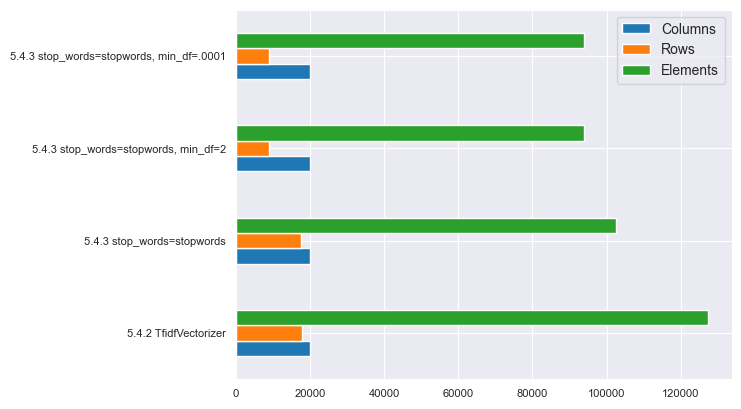

In [50]:
show(matrix_data)

### Maximum frequency

We can use the `max_df` parameter to eliminate terms occurring too often in the corpus. Here we eliminate all words that appear in at least 10% of the headlines. 

We can see that a setting of 10% does not eliminate any words, implying our news headlines are very diverse.

In [51]:
tfidf = TfidfVectorizer(stop_words=stopwords, max_df=0.1)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, max_df=0.1')

Columns        20,000
Rows           17,662
Elements      102,517
Bytes         820,136
Gigabytes     0.00076


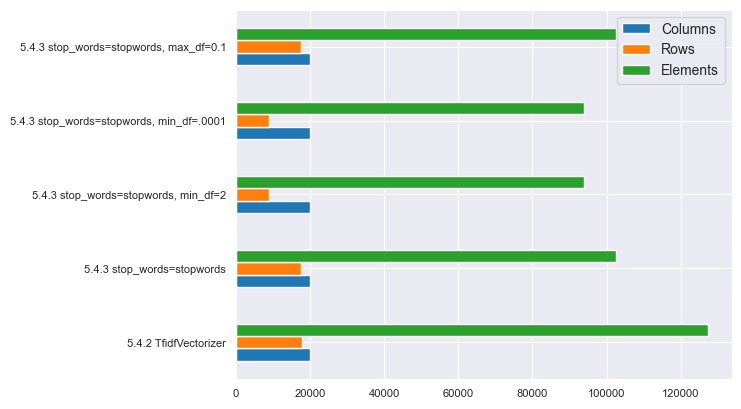

In [52]:
show(matrix_data)

### n-grams

In [53]:
tfidf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, ngram_range=(1,2), min_df=2')

Columns        20,000
Rows           14,194
Elements      110,115
Bytes         880,920
Gigabytes     0.00082


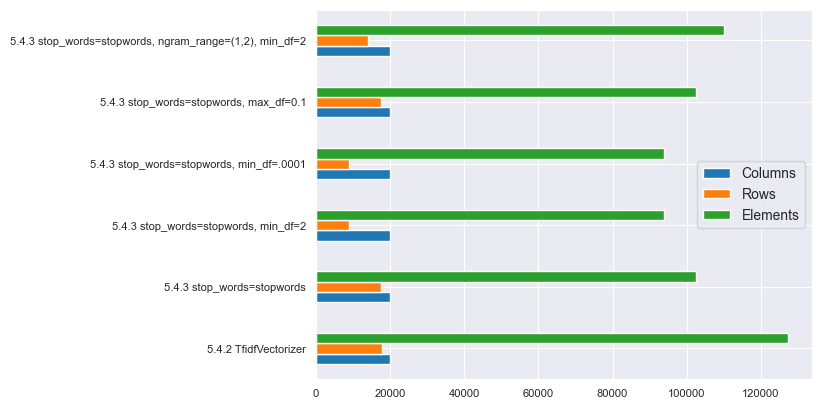

In [54]:
show(matrix_data)

In [55]:
tfidf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=2)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, ngram_range=(1,3), min_df=2')

Columns        20,000
Rows           14,834
Elements      111,727
Bytes         893,816
Gigabytes     0.00083


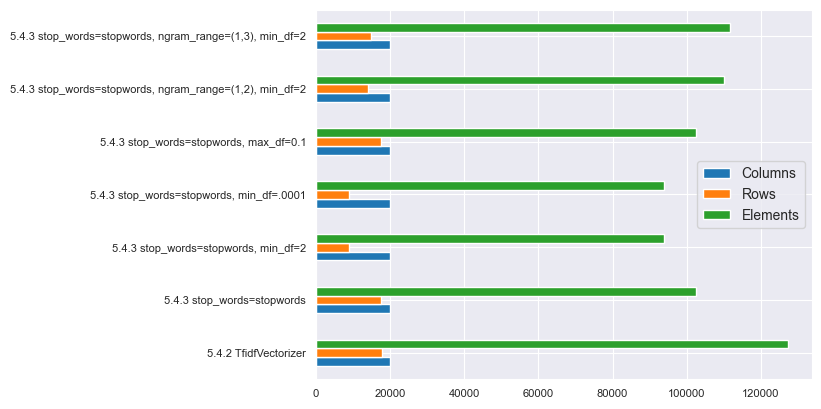

In [56]:
show(matrix_data)

<a name='5.4.4'></a><a id='5.4.4'></a>
## 5.4.4 Blueprint: Improving Features by Making Them More Specific
<a href="#top">[back to top]</a>

Up to now, we have used the original headline words, and reduced the number of dimensions by stop words and counting frequencies. 

However, we have not changed the features themselves. Next, we can use linguistic analysis for more possibilities. 

### Lemmas

Using spaCy, we can lemmatize all headlines and keep only the lemmas. This results in a smaller vocabulary. 

First, we have to perform a linguistic analysis. 

---
Pandas Note: `headlines.at`

Access a single value for a row/column label pair.

Similar to `loc`, in that both provide label-based lookups. 

Use `at` if you only need to get or set a single value in a DataFrame
or Series.


    .loc can take multiple rows and columns as input arguments
    .at can only take one row and one column as input arguments

    DataFrame.at: Access a single value for a row/column pair by label.
    DataFrame.iat: Access a single value for a row/column pair by integer position.
    DataFrame.loc: Access a group of rows and columns by label(s).
    DataFrame.iloc: Access a group of rows and columns by integer position(s).

In [57]:
%%time
# This takes a long time to run!

nlp = spacy.load("en_core_web_sm")

nouns_adjectives_verbs = ["NOUN", "PROPN", "ADJ", "ADV", "VERB"]

for i, row in tqdm(headlines.iterrows(), total=len(headlines)):
    doc = nlp(str(row["headline_text"]))
    headlines.at[i, "lemmas"] = " ".join([token.lemma_ for token in doc])
    headlines.at[i, "nav"] = " ".join([token.lemma_ for token in doc if token.pos_ in nouns_adjectives_verbs])

  0%|          | 0/20000 [00:00<?, ?it/s]

CPU times: user 2min 15s, sys: 1.94 s, total: 2min 17s
Wall time: 6h 2min 6s


In [58]:
# Compare
headlines[["lemmas", "headline_text", "nav"]].head()

,lemmas,headline_text,nav
630573,abc sport news,abc sport news,abc sport news
507323,tis the season to be give to yourself,tis the season to be giving to yourself,tis season give
627783,doubt cast over mingela water plan,doubt cast over mingela water plan,doubt cast mingela water plan
653687,bombing of darwin nday,bombing of darwin nday,bombing darwin nday
112626,group make 18b bid for wa pipeline,group makes 18b bid for wa pipeline,group make 18b bid wa pipeline


In [59]:
headlines.to_csv('headlines_lemma.csv')
headlines.to_pickle("headlines_lemma.pkl")
!ls -l *.csv
!ls -l *.pkl

-rw-r--r--  1 gb  staff  2675631 Mar 31 05:30 headlines_lemma.csv
-rw-r--r--  1 gb  staff  2755533 Mar 31 05:30 headlines_lemma.pkl


<a name='5.4.5'></a><a id='5.4.5'></a>
## 5.4.5 Blueprint: Using Lemmas Instead of Words for Vectorizing Documents
<a href="#top">[back to top]</a>

After the previous linguistic analysis, we can vectorize the data using the lemmas, and see how the vocabulary decreased. 

In [60]:
tfidf = TfidfVectorizer(stop_words=stopwords)
dt = tfidf.fit_transform(headlines["lemmas"].map(str))

examine_matrix(dt, '5.4.5 stop_words=stopwords, headlines["lemmas"]')

Columns        20,000
Rows           14,403
Elements      100,702
Bytes         805,616
Gigabytes     0.00075


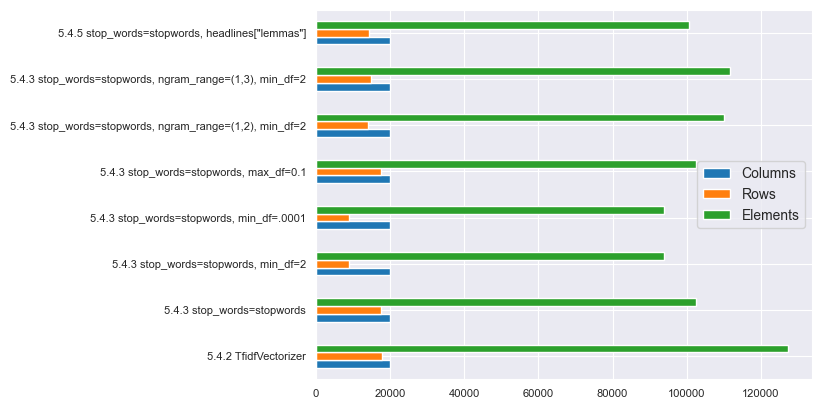

In [61]:
show(matrix_data)

<a name='5.4.6'></a><a id='5.4.6'></a>
## 5.4.6 Blueprint: Limit Word Types
<a href="#top">[back to top]</a>

With our data now, we can restrict operations to just nouns, adjectives and verbs for vectorization. This assumes prepositions, conjugations, etc carry little meaning. 

In [62]:
tfidf = TfidfVectorizer(stop_words=stopwords)
dt = tfidf.fit_transform(headlines["nav"].map(str))

examine_matrix(dt, '5.4.6 stop_words=stopwords, headlines["nav"]')

Columns        20,000
Rows           14,036
Elements       98,927
Bytes         791,416
Gigabytes     0.00074


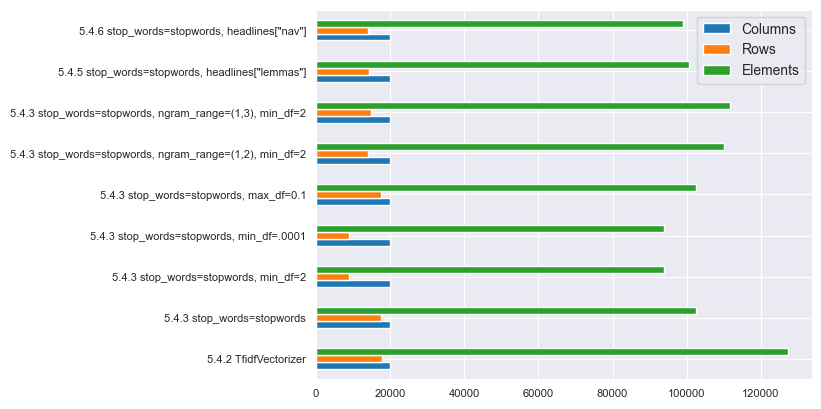

In [63]:
show(matrix_data)

<a name='5.4.7'></a><a id='5.4.7'></a>
## 5.4.7 Blueprint: Remove Most Common Words
<a href="#top">[back to top]</a>

We can try removing the most common English words via a list from Google. 

### remove top 10,000

<a id='google-10000-english.txt'></a><a name='google-10000-english.txt'></a>
### Dataset: google-10000-english.txt
<a href="#top">[back to top]</a>

In [64]:
google_10k_file = 'google-10000-english.txt'
!wget -nc -q https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english.txt
!ls -l {google_10k_file}

-rw-r--r--  1 gb  staff  75888 Mar 31 05:30 google-10000-english.txt


In [65]:
top_10000 = pd.read_csv(google_10k_file, header=None)

top_10000.describe()

,0
count,9999
unique,9999
top,the
freq,1


In [66]:
top_10000.sample(3)

,0
6732,stuart
2169,im
410,article


In [67]:
tfidf = TfidfVectorizer(
    stop_words=list(set(top_10000.iloc[:,0].values))
)
dt = tfidf.fit_transform(headlines["nav"].map(str))

examine_matrix(dt, '5.4.7 remove top 10K, headlines["nav"]')

Columns        20,000
Rows            9,371
Elements       24,670
Bytes         197,360
Gigabytes     0.00018


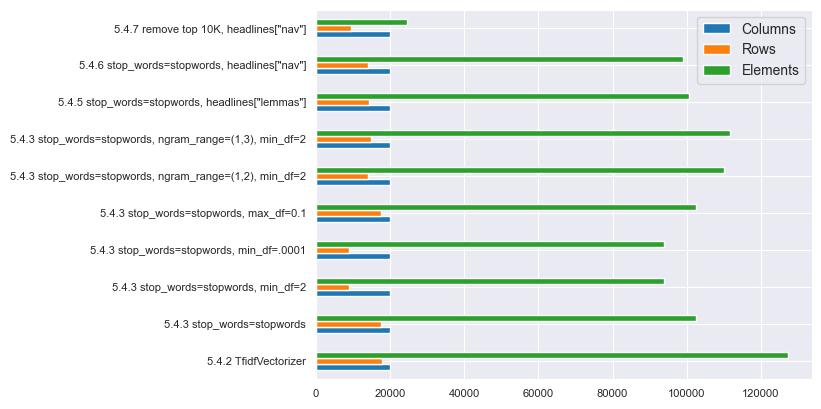

In [68]:
show(matrix_data)

<a name='5.4.8'></a><a id='5.4.8'></a>
## 5.4.8 Blueprint: Adding Context via N-Grams
<a href="#top">[back to top]</a>

Up to now, we have only used single words as features as the basis for our vectorization. In this strategy, we have lost a lot of context information.

Here, we use a simple method to represent word combinations, called *n-grams*. 

### bigrams

In [69]:
tfidf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2) 
dt = tfidf.fit_transform(headlines["headline_text"])
print("Bigrams")

examine_matrix(dt, '5.4.8 stop_words=stopwords, ngram_range=(1,2), min_df=2')

Bigrams
Columns        20,000
Rows           14,194
Elements      110,115
Bytes         880,920
Gigabytes     0.00082


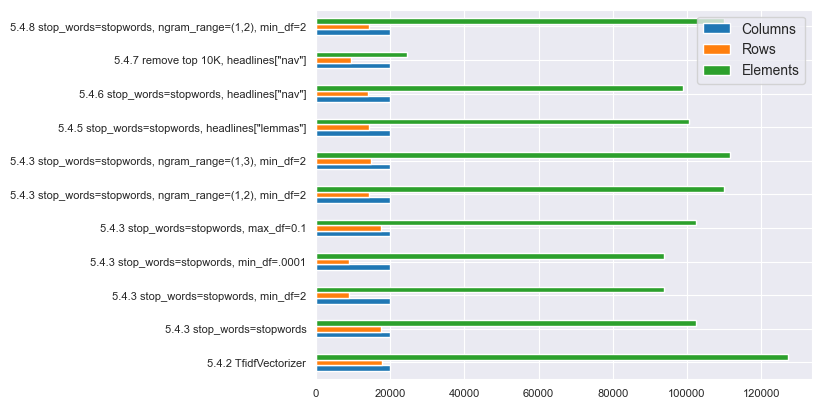

In [70]:
show(matrix_data)

### trigrams

In [71]:
tfidf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=2) 
dt = tfidf.fit_transform(headlines["headline_text"])
print("Trigrams")

examine_matrix(dt, '5.4.8 stop_words=stopwords, ngram_range=(1,3), min_df=2')

Trigrams
Columns        20,000
Rows           14,834
Elements      111,727
Bytes         893,816
Gigabytes     0.00083


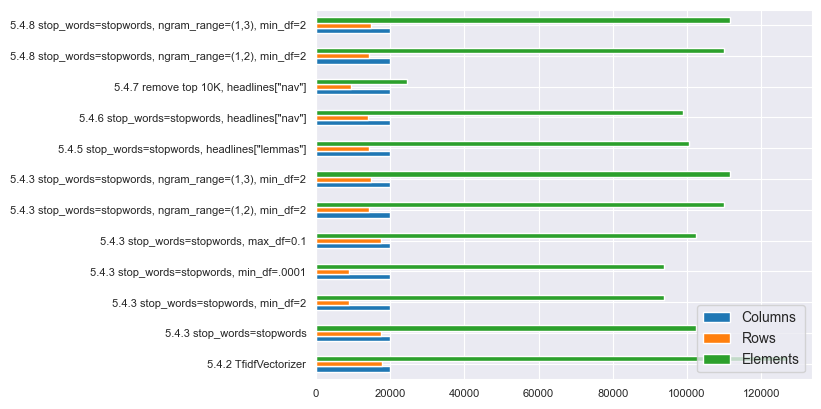

In [72]:
show(matrix_data)

### bigrams with linguistic features (nav)

Combining n-grams with linguistic features and common words is also possible and reduces the vocabulary size considerably.

In [73]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    stop_words=list(set(top_10000.iloc[:,0].values))
)
dt = tfidf.fit_transform(headlines["nav"].map(str))

print("Bigrams and Stopwords")

examine_matrix(dt, '5.4.8 ngram_range=(1,2), headlines["nav"]')

Bigrams and Stopwords
Columns        20,000
Rows           18,723
Elements       34,370
Bytes         274,960
Gigabytes     0.00026


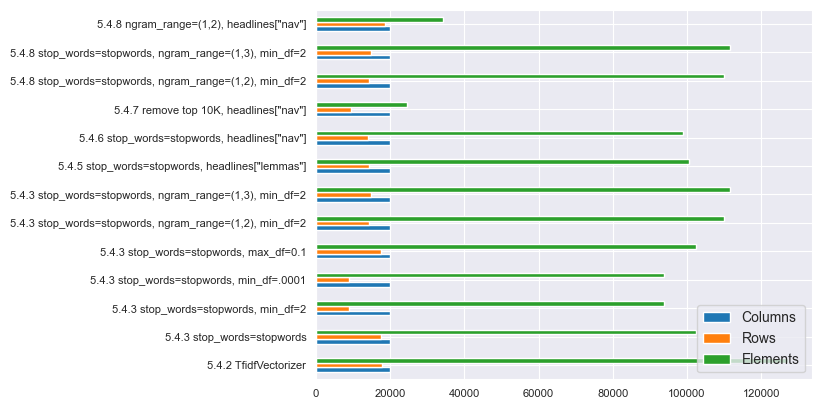

In [74]:
show(matrix_data)

<a name='5.5'></a><a id='5.5'></a>
# 5.5 Syntactic Similarity in the ABC Dataset
<a href="#top">[back to top]</a>

*Similarity* is one of the most basic concepts in machine learning and text analytics. Here we explore the more difficult problems finding similar documents in the ABC dataset. 

First, vectorize the dataset using stop words and bigrams. 

In [75]:
stopwords.append("test")

tfidf = TfidfVectorizer(
    stop_words=stopwords, 
    min_df=2,
    ngram_range=(1,2),
    norm='l2'
)

dt = tfidf.fit_transform(headlines["headline_text"].map(str))

examine_matrix(dt, '5.5 headline_text, norm=l2')

Columns        20,000
Rows           14,182
Elements      109,989
Bytes         879,912
Gigabytes     0.00082


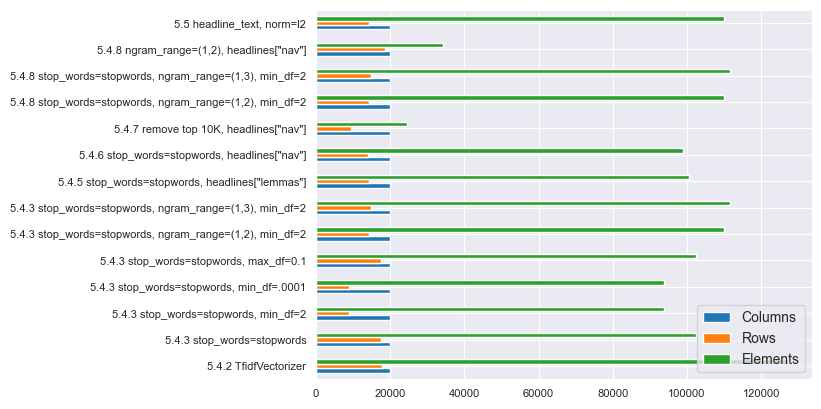

In [76]:
show(matrix_data)

<a name='5.5.1'></a><a id='5.5.1'></a>
## 5.5.1 Blueprint: Finding Most Similar Headlines to a Made-up Headline
<a href="#top">[back to top]</a>

To search for a headline, we just have to vectorize our new document-query. 

In [77]:
query = "australia and new zealand discuss optimal apple size"
print(query)
HR()

made_up = tfidf.transform([query])
made_up

australia and new zealand discuss optimal apple size
----------------------------------------


<1x14182 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [78]:
made_up.__dict__

{'_shape': (1, 14182),
 'maxprint': 50,
 'indices': array([14167, 11638,  8599,  8525,  3774,   979,   976,   718],
       dtype=int32),
 'indptr': array([0, 8], dtype=int32),
 'data': array([0.36134792, 0.43489134, 0.36134792, 0.21282175, 0.34132182,
        0.43489134, 0.24648616, 0.37154448])}

In [79]:
for x in made_up:
    print(x)

  (0, 14167)	0.36134791862648286
  (0, 11638)	0.43489133799396096
  (0, 8599)	0.36134791862648286
  (0, 8525)	0.2128217452870869
  (0, 3774)	0.3413218176341249
  (0, 979)	0.43489133799396096
  (0, 976)	0.24648616436802318
  (0, 718)	0.3715444845496938


We need to calculate the cosine similarity to each headline in the corpus. We can use `cosine_similarity` for this.

In [80]:
sim = cosine_similarity(made_up, dt)

The result is a number of headlines in the corpus x 1 matrix, where each number represents the similarity to a document in the corpus. Using `np.argmax` gives us the index of the most similar document.

In [81]:
sim[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [82]:
# Get the top-5
headlines.iloc[np.argsort(sim[0])[::-1][0:5]][["publish_date", "lemmas"]]

,publish_date,lemmas
918759,2014-11-19,netflix to expand into australia new zealand
942902,2015-03-29,cricket world cup final australia new zealand
219545,2006-02-20,australia new zealand close to joint world cup...
1012189,2016-02-21,new zealand vs australia second test day two blog
959018,2015-06-10,huge change in new zealand agriculture


<a name='5.5.2'></a><a id='5.5.2'></a>
## 5.5.2 Blueprint: Finding the Two Most Similar Documents in a Large Corpus (Much More Difficult)
<a href="#top">[back to top]</a>

We want to search for duplicates in this corpus. We cannot simply calculate the `cosine_similarity` between all documents anymore, because of the larger size of the dataset. 

Instead, we use other optimizations. One method is to calculate only the subdiagonal elements of the similarity matrix. 

We can then divide the problem into different blocks and calculate similarity submatrices. 

NOTE ON TfidfVectorizer API:

* norm: {‘l1’, ‘l2’} or None, default=’l2’

    Each output row will have unit norm, either:

    - ‘l2’: Sum of squares of vector elements is 1. The cosine similarity between two vectors is their dot product when l2 norm has been applied.
    - ‘l1’: Sum of absolute values of vector elements is 1. See preprocessing.normalize.
    - None: No normalization.


    

In [83]:
# There are "test" headlines in the corpus
stopwords.append("test")

# Achieve speed up via normalizing the TF-IDF vectors with norm='l2'
tfidf = TfidfVectorizer(
    stop_words=stopwords, 
    ngram_range=(1,2), 
    min_df=2, 
    norm='l2'
)

dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.5.2 headline_text, norm=l2')

Columns        20,000
Rows           14,182
Elements      109,989
Bytes         879,912
Gigabytes     0.00082


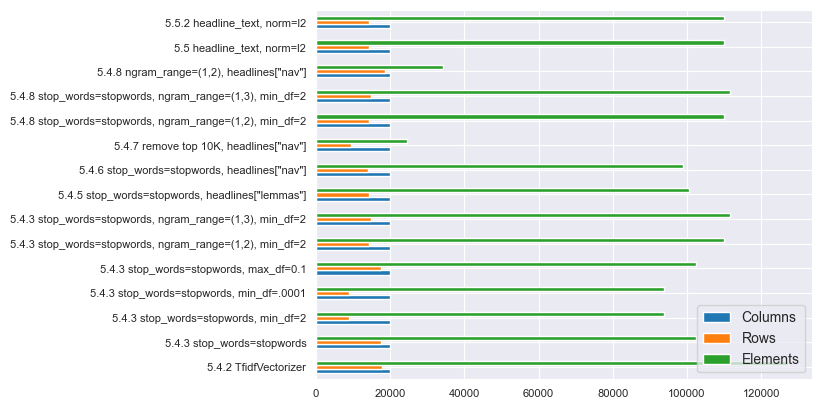

In [84]:
show(matrix_data)

### Timing Cosine Similarity

In [85]:
%%time
cosine_similarity(dt[0:10000], dt[0:10000], dense_output=False)

CPU times: user 28.9 ms, sys: 10 ms, total: 38.9 ms
Wall time: 37.7 ms


<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1306543 stored elements in Compressed Sparse Row format>

In [86]:
%%time
r = cosine_similarity(dt[0:10000], dt[0:10000])
r[r > 0.9999] = 0
print(np.argmax(r))

81178507
CPU times: user 500 ms, sys: 386 ms, total: 886 ms
Wall time: 9min 48s


In [87]:
%%time
r = cosine_similarity(dt[0:10000], dt[0:10000], dense_output=False)
r[r > 0.9999] = 0
print(np.argmax(r))

85078117
CPU times: user 277 ms, sys: 138 ms, total: 416 ms
Wall time: 3.72 s


### Timing Dot-Product

In [88]:
%%time
r = np.dot(dt[0:10000], np.transpose(dt[0:10000]))
r[r > 0.9999] = 0
print(np.argmax(r))

85078117
CPU times: user 227 ms, sys: 33.9 ms, total: 261 ms
Wall time: 267 ms


### Batch

In [89]:
%%time
batch = 10_000
max_sim = 0.0
max_a = None
max_b = None

for a in range(0, dt.shape[0], batch):
    for b in range(0, a+batch, batch):
        print(a, b)
        #r = np.dot(dt[a:a+batch], np.transpose(dt[b:b+batch]))
        r = cosine_similarity(dt[a:a+batch], dt[b:b+batch], dense_output=False)
        
        # Eliminate identical vectors by setting similarity to np.nan which gets sorted out
        r[r > 0.9999] = 0
        sim = r.max()
        if sim > max_sim:
            # argmax returns a single value which we have to map to the two dimensions            
            (max_a, max_b) = np.unravel_index(np.argmax(r), r.shape)
            # Adjust offsets in corpus (this is a submatrix)
            max_a += a
            max_b += b
            max_sim = sim

0 0
10000 0
10000 10000
CPU times: user 625 ms, sys: 94 ms, total: 719 ms
Wall time: 862 ms


In [90]:
print(max_a, max_b)

18372 6978


In [91]:
print(headlines.iloc[max_a])
HR()
print(headlines.iloc[max_b])

publish_date                                2013-09-22 00:00:00
headline_text    man charged over fatal hit and run in brisbane
lemmas            man charge over fatal hit and run in brisbane
nav                           man charge fatal hit run brisbane
Name: 821537, dtype: object
----------------------------------------
publish_date                2005-11-07 00:00:00
headline_text    man charged over fatal hit run
lemmas            man charge over fatal hit run
nav                    man charge fatal hit run
Name: 199113, dtype: object


In [92]:
print(max_sim)

0.9588870062270105


In [93]:
pd.set_option('max_colwidth', -1)
headlines.iloc[[max_a, max_b]][["publish_date", "headline_text"]]

,publish_date,headline_text
821537,2013-09-22,man charged over fatal hit and run in brisbane
199113,2005-11-07,man charged over fatal hit run


<a name='5.5.3'></a><a id='5.5.3'></a>
## 5.5.3 Blueprint: Finding Related Words
<a href="#top">[back to top]</a>

Instead of just word-similarity, we want to obtain information about related words. We define words as "related" if they frequently appear together in documents. 

Here, instead of working with a document-term matrix, we switch to a *term-document matrix*, which is just its transposed form. Instead of taking row vectors, we now take column vectors. However, we need to re-vectorize the data. 

In [94]:
tfidf_word = TfidfVectorizer(
    stop_words=stopwords, 
    min_df=50 # 1000
)

dt_word = tfidf_word.fit_transform(
    headlines["headline_text"]
)

examine_matrix(dt_word, '5.5.3 min_df=50')

Columns        20,000
Rows              330
Elements       31,381
Bytes         251,048
Gigabytes     0.00023


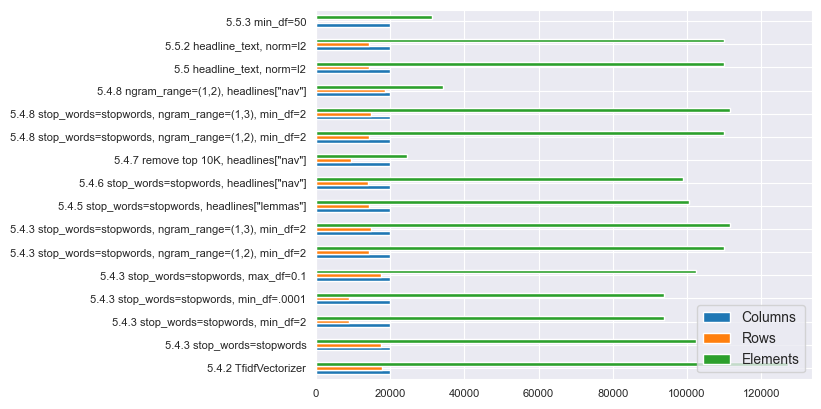

In [95]:
show(matrix_data)

Because the vocabulary is small, we can directly calculate the cosine similarity. We change the row for column vectors, and transpose the matrix.

In [96]:
r = cosine_similarity(dt_word.T, dt_word.T)
np.fill_diagonal(r, 0)

Finding the largest entries is easiest if we convert it to a one-dimensional array, get the index of the sorted elements via np.argsort, and restore the original indices for the vocabulary lookup.

In [97]:
voc = tfidf_word.get_feature_names_out()

size = r.shape[0] # quadratic
for index in np.argsort(r.flatten())[::-1][0:40]:
    a = int(index/size)
    b = index%size
    spacer = ""
    if a > b:  # avoid repetitions
        print(f'{voc[a]:<9} related to {spacer:<2} {voc[b]}')

hour      related to    country
gold      related to    coast
climate   related to    change
podcast   related to    hour
share     related to    market
news      related to    abc
world     related to    cup
search    related to    missing
fatal     related to    crash
run       related to    hit
podcast   related to    country
child     related to    abuse
plane     related to    crash
rise      related to    rates
legal     related to    action
rise      related to    rate
station   related to    power
man       related to    charged
south     related to    east
sex       related to    abuse


<a name='5.5.4'></a><a id='5.5.4'></a>
## 5.5.4 Tips for Long-Running Programs like Syntactic Similarity
<a href="#top">[back to top]</a>

No source code.